In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv', index_col='id')

pd.concat([train_data, test_data]).info()

<class 'pandas.core.frame.DataFrame'>
Index: 32033 entries, 0 to 32032
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              32033 non-null  int64  
 1   X_Maximum              32033 non-null  int64  
 2   Y_Minimum              32033 non-null  int64  
 3   Y_Maximum              32033 non-null  int64  
 4   Pixels_Areas           32033 non-null  int64  
 5   X_Perimeter            32033 non-null  int64  
 6   Y_Perimeter            32033 non-null  int64  
 7   Sum_of_Luminosity      32033 non-null  int64  
 8   Minimum_of_Luminosity  32033 non-null  int64  
 9   Maximum_of_Luminosity  32033 non-null  int64  
 10  Length_of_Conveyer     32033 non-null  int64  
 11  TypeOfSteel_A300       32033 non-null  int64  
 12  TypeOfSteel_A400       32033 non-null  int64  
 13  Steel_Plate_Thickness  32033 non-null  int64  
 14  Edges_Index            32033 non-null  float64
 15  Empty_I

* Combining the datasets, we can see there are no null values across both the training and testing data. 
* Target values are binary (0/1), and below you can see that many of these features are unbalanced.
* For some of the target values, we can observe there are no faults for certain steel plates. Plates with multiple faults will be placed into the 'Other_Faults' category and those without faults will be removed from the dataset.
* All features appear to be numerical.

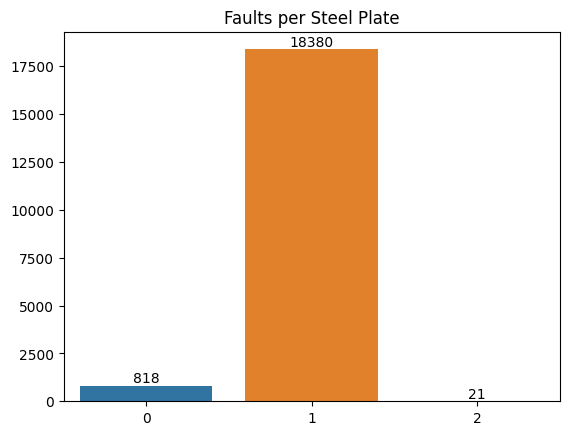

In [3]:
target_features = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_data = train_data[target_features]

fault_counts = np.unique(target_data.sum(axis=1), return_counts=True)
ax = sns.barplot(x=fault_counts[0], y=fault_counts[1])
ax.bar_label(ax.containers[0], fontsize=10)
plt.title("Faults per Steel Plate")
plt.show()

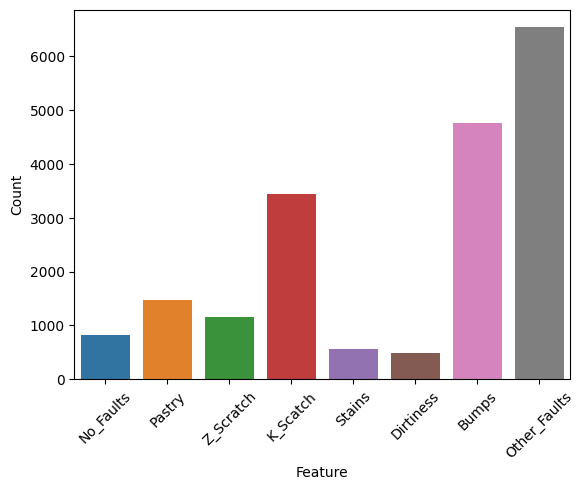

In [4]:
target = target_data@(np.arange(target_data.shape[1])+1)
target[target_data.sum(axis=1)==2] = 3

ax = sns.countplot(x=target)

tick_labels = list(target_data.columns)
tick_labels.insert(0, 'No_Faults')

ax.set(xlabel='Feature', ylabel='Count', xticklabels=tick_labels)
ax.tick_params(axis='x', rotation=45)
plt.show()

In [5]:
train_data.drop(np.where(target_data.sum(axis=1) == 0)[0], inplace=True)

In [6]:
def add_new_features(df):
    df['X_Range'] = df['X_Maximum'] - df['X_Minimum']
    df['Y_Range'] = df['Y_Maximum'] - df['Y_Minimum']
    
    df['Range_of_Luminosity'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']

    df['Total_Perimeter'] = df['X_Perimeter'] + df['Y_Perimeter']
    df['Area_Perimeter_Ratio'] = df['Pixels_Areas'] / df['Total_Perimeter']
    
    return df

In [7]:
train_data = add_new_features(train_data)
test_data = add_new_features(test_data)

print('Train size: ', train_data.shape)
print('Test size: ', test_data.shape)

print('\nAll Features: \n', train_data.columns.values)

Train size:  (18401, 39)
Test size:  (12814, 32)

All Features: 
 ['X_Minimum' 'X_Maximum' 'Y_Minimum' 'Y_Maximum' 'Pixels_Areas'
 'X_Perimeter' 'Y_Perimeter' 'Sum_of_Luminosity' 'Minimum_of_Luminosity'
 'Maximum_of_Luminosity' 'Length_of_Conveyer' 'TypeOfSteel_A300'
 'TypeOfSteel_A400' 'Steel_Plate_Thickness' 'Edges_Index' 'Empty_Index'
 'Square_Index' 'Outside_X_Index' 'Edges_X_Index' 'Edges_Y_Index'
 'Outside_Global_Index' 'LogOfAreas' 'Log_X_Index' 'Log_Y_Index'
 'Orientation_Index' 'Luminosity_Index' 'SigmoidOfAreas' 'Pastry'
 'Z_Scratch' 'K_Scatch' 'Stains' 'Dirtiness' 'Bumps' 'Other_Faults'
 'X_Range' 'Y_Range' 'Range_of_Luminosity' 'Total_Perimeter'
 'Area_Perimeter_Ratio']


In [8]:
X = train_data.drop(columns=target_features)
y = train_data[target_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [9]:
def fit_data(x_data, y_data, defect, params={}):
    model = XGBClassifier(**params, random_state=0)
    model.fit(x_data, y_data[defect])
    
    preds = model.predict_proba(x_data)
    auc = round(roc_auc_score(y_data, preds) * 100, 2)
    
    print(defect, ":",  auc, "%")
    roc_auc_scores.append(auc)

    return model

In [10]:
print("Training  ROC-AUC scores:\n")
roc_auc_scores = list()
models = dict()

for defect in target_features:
    model = fit_data(X_train, y_train, defect)
    models[defect] = model
    
print("\nOverall score: ", round(np.mean(roc_auc_scores),2), "%")

Training  ROC-AUC scores:

Pastry : 22.69 %
Z_Scratch : 78.59 %
K_Scatch : 47.65 %
Stains : 47.33 %
Dirtiness : 42.47 %
Bumps : 46.5 %
Other_Faults : 46.49 %

Overall score:  47.39 %


In [11]:
for defect_name in models:
    submission[defect_name] = models[defect_name].predict_proba(test_data)

In [12]:
submission.to_csv('submission.csv')
submission.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
19219,0.496460,0.999984,0.999964,0.999998,0.995373,0.944661,0.706441
19220,0.953727,0.998437,0.999463,0.999997,0.914361,0.876614,0.816958
19221,0.999765,0.995209,0.903220,0.999975,0.999142,0.830802,0.483399
19222,0.853830,0.999879,0.999982,0.999985,0.996877,0.746399,0.304301
19223,0.999858,0.999997,0.999996,0.999397,0.999545,0.225658,0.643005
